# Dementia Classfication with Differentially Expressed Genes

Taking inspiration from similar studies such as [Arzouni et al 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7717689/), we aim to use the differentially expressed genes to train supervsed machine learning models to classifiy dementia patients and determine the most impactful genes that influence this classification.

Our methodology differs in several ways, most specifically keeps all patients and samples and do not exclude patients with previous history of TBI.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle as pkl
import pandas as pd
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from de_ml_functions import prep_data, train_test_val_split, train_models
import matplotlib.pyplot as plt
import seaborn as sns



## Data Prep

We begin by preparing the data appropriately for machine learning models. There are several samples per donor, so it is important that we separate the samples across training and testing sets by donor to prevent data leakage. We use a custom splitting function to accomplish this. The resulting data is a 70-15-15 split by donor_id.

There were 32 genes extracted from both the pydeseq2 and the limma voom differential expression pipeline. All 32 were used in training these models. The gene data was appened to the counts matricx and scaled by with the StandardScaler trained on the training data. 

In [2]:
ml_df, donor_ids, samples = prep_data()
X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(ml_df,donor_ids, samples)

In [3]:
# Sheck the shape of the resulting data
X_train.shape, X_val.shape, X_test.shape

((164, 32), (88, 32), (125, 32))

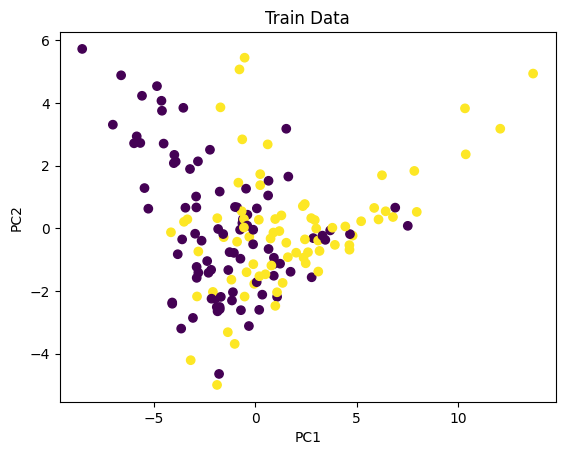

In [4]:
### Decision Boundary Testing
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state = 42)
X_ = pca.fit_transform(X_train)

plt.scatter(X_[:,0], X_[:,1], c = y_train, label = y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Train Data')
plt.show()

Text(0.5, 1.0, 'Val Data')

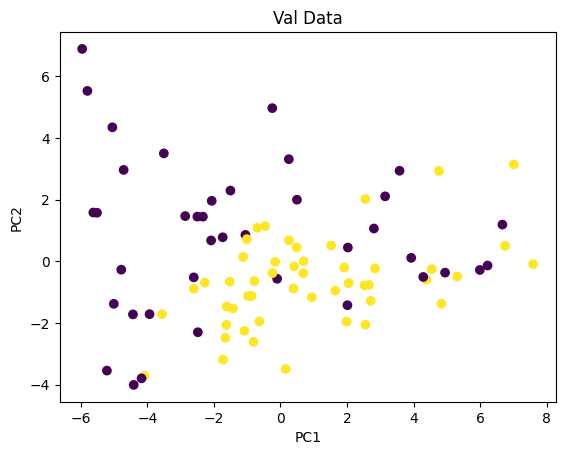

In [5]:
X_ = pca.fit_transform(X_val)
plt.scatter(X_[:,0], X_[:,1], c = y_val, label = y_val)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Val Data')

Text(0.5, 1.0, 'Test Data')

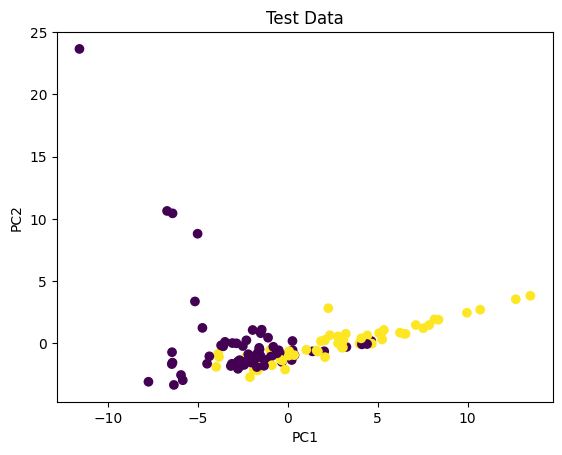

In [6]:
X_ = pca.fit_transform(X_test)
plt.scatter(X_[:,0], X_[:,1], c = y_test, label = y_test)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Test Data')

The result is that about half of the samples are in the training set, and the other half is split between the validation and test set.

## Base Models

Next we train a series of base classifiers and example their performance:

In [20]:
# Define models to test
models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    SVC(kernel="linear", random_state=42),
    SVC(kernel="rbf", random_state=42),
    GaussianNB(),
    GradientBoostingClassifier(random_state=42),
    DummyClassifier(strategy="most_frequent", random_state=42),
]

# List of model_names for output
model_names = [
    "Log_Reg",
    "DT",
    "RF",
    "SVM_linear",
    "SVM_radial",
    "GaussianNB",
    "Gradient_boosted",
    "Dummy_most_freq",
]

In [21]:
# Train and score valuation data
model_scores_train = train_models(models, model_names, X_train, y_train, X_val, y_val)
model_scores_train.sort_values(by = 'f1', ascending=False)

,accuracy,precision,recall,f1
GaussianNB,0.8125,0.866667,0.812500,0.838710
SVM_radial,0.7250,0.825000,0.687500,0.750000
Gradient_boosted,0.7125,0.820513,0.666667,0.735632
Log_Reg,0.6875,0.780488,0.666667,0.719101
SVM_linear,0.6750,0.761905,0.666667,0.711111
RF,0.6625,0.800000,0.583333,0.674699
DT,0.6375,0.806452,0.520833,0.632911
Dummy_most_freq,0.4000,0.000000,0.000000,0.000000


The GaussianNB, SVM with the radial kernal, and the gridient boosted decision tree have the overall best performance on the data. Moving forward we aim to improve and evaluate these models on the holdout data.

First we evaluate the models on the holdout data for base scores before final tuning and evauluation.

In [22]:
model_scores_test = train_models(models, model_names, X_train, y_train, X_test, y_test)
model_scores_test.sort_values(by = 'f1', ascending=False)

,accuracy,precision,recall,f1
GaussianNB,0.757009,0.725490,0.755102,0.740000
SVM_radial,0.672897,0.666667,0.571429,0.615385
RF,0.644860,0.627907,0.551020,0.586957
Gradient_boosted,0.607477,0.574468,0.551020,0.562500
DT,0.598131,0.571429,0.489796,0.527473
Log_Reg,0.616822,0.611111,0.448980,0.517647
SVM_linear,0.616822,0.617647,0.428571,0.506024
Dummy_most_freq,0.542056,0.000000,0.000000,0.000000


## Model Tuning
The gaussian model requires no tuning so we move to tuning the SVM model.

### SVM model

In [23]:
# SVM tuning and evaluation
kernels = ["linear", "rbf"]
C = [100, 10, 1.0, 0.1, 0.001]
gammas = [0.1, 1, 10, 100, "scale"]

score_names = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    #   'roc_auc'
]

results = []
for kernel in kernels:
    for c in C:
        for gamma in gammas:
            clf = SVC(kernel=kernel, C=c, gamma=gamma, random_state=42)
            clf.fit(X_train, y_train)
            preds = clf.predict(X_val)
            accuracy_scores = accuracy_score(y_val, preds)
            precision_scores = precision_score(y_val, preds)
            recall_scores = recall_score(y_val, preds)
            f1_scores = f1_score(y_val, preds)
            # roc_auc_scores = roc_auc_score(y_val,preds)

            results.append(
                (
                    (kernel, c, gamma),
                    accuracy_scores,
                    precision_scores,
                    recall_scores,
                    f1_scores,
                    # roc_auc_scores,
                )
            )

# View top params based on accuracy
SVC_tuning_df = pd.DataFrame(results, columns=["params"] + score_names).sort_values(
    by="f1", ascending=False
)
SVC_tuning_df.head()

,params,accuracy,precision,recall,f1
39,"(rbf, 1.0, scale)",0.725,0.825000,0.687500,0.75000
19,"(linear, 0.1, scale)",0.700,0.815789,0.645833,0.72093
18,"(linear, 0.1, 100)",0.700,0.815789,0.645833,0.72093
17,"(linear, 0.1, 10)",0.700,0.815789,0.645833,0.72093
16,"(linear, 0.1, 1)",0.700,0.815789,0.645833,0.72093


The base svm model is actually the best perfoming model in this case.

The number of feeatures and the best learning rate for the gradient booseted tree will be assessed.

### Gradient Boosted Model

In [24]:
# Gradient Boosted tuning and evaluation
# max_features = list(range(5,13))+ [None] # Max features between 5 and 12 or all
max_features = [None]
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
max_depth = list(range(3,10)) # Max Tree depth between 3 and 9


score_names = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    #   'roc_auc'
]

close_results = []
train_results = []
val_results = []
best_score = 0
for mf in max_features:
    for lr in learning_rate:
        for md in max_depth:
            clf = GradientBoostingClassifier(max_features=mf, learning_rate=lr, max_depth=md, random_state=42)
            clf.fit(X_train, y_train)

            # Train Scores
            preds = clf.predict(X_train)
            # accuracy_scores = accuracy_score(y_train, preds)
            # precision_scores = precision_score(y_train, preds)
            # recall_scores = recall_score(y_train, preds)
            f1_scores = f1_score(y_train,preds)
            # roc_auc_scores = roc_auc_score(y_train,preds[:,1])


            train_score = f1_scores
            train_results.append(train_score)

            # Val scores
            preds = clf.predict(X_val)
            # accuracy_scores = accuracy_score(y_val, preds)
            # precision_scores = precision_score(y_val, preds)
            # recall_scores = recall_score(y_val, preds)
            f1_scores = f1_score(y_val,preds)
            # roc_auc_scores = roc_auc_score(y_val,preds[:,1])

            val_score = f1_scores
            val_results.append(val_score)

            if val_score > best_score:
                best_score = val_score
                best_model = clf


In [25]:
best_score, best_model

(0.7356321839080459, GradientBoostingClassifier(random_state=42))

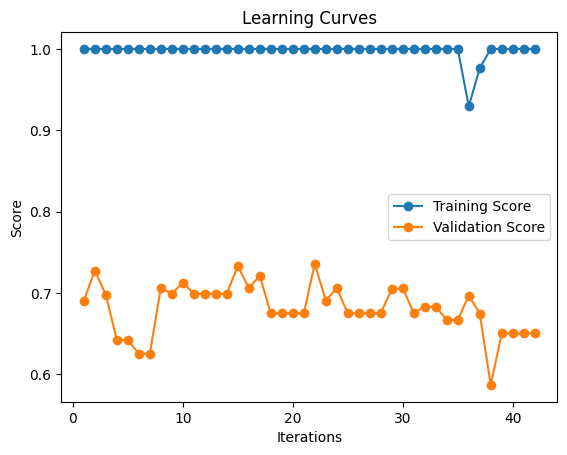

In [26]:
def plot_learning_curves(train_scores, val_scores):
    iterations = range(1, len(train_scores) + 1)

    plt.plot(iterations, train_scores, label='Training Score', marker='o')
    plt.plot(iterations, val_scores, label='Validation Score', marker='o')

    plt.xlabel('Iterations')
    plt.ylabel('Score')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

# Example usage

plot_learning_curves(train_results, val_results)

The model generally appears to be underfitting. But performs the best on the validation set at a learing rate of 0.25, and a max depth of 6

Now to take a look at this model's performance on the holdout set:

In [27]:
# Define models to test
models = [
    best_model,
]

# List of model_names for output
model_names = [
    "Gradient_boosted",
]
train_models(models, model_names, X_train, y_train, X_test, y_test)

,accuracy,precision,recall,f1
Gradient_boosted,0.607477,0.574468,0.55102,0.5625


Unsuprisingly, the tuned model does not perform well on the testing data. It actually performs worse than the base model on both the training and validation data.

For good measure we tune a logistic regression model as well.

### Logistic Regession

In [28]:
# Log_reg tuning and evaluation
C = [0.001, 0.01, 0.1, 1, 10, 100]
# C = np. linspace(0.001, 100, 10)


score_names = [
    "accuracy",
    "precision",
    "recall",
    "f1",
    #   'roc_auc'
]

close_results = []
train_results = []
val_results = []
best_train_score = 0
best_val_score = 0
for c in C:
    clf = LogisticRegression(C= c, random_state=42)
    clf.fit(X_train, y_train)

    # Train Scores
    preds = clf.predict(X_train)
    # accuracy_scores = accuracy_score(y_train, preds)
    # precision_scores = precision_score(y_train, preds)
    # recall_scores = recall_score(y_train, preds)
    f1_scores = f1_score(y_train,preds)
    # roc_auc_scores = roc_auc_score(y_train,preds[:,1])


    train_score = f1_scores
    train_results.append(train_score)

    # Val scores
    preds = clf.predict(X_val)
    # accuracy_scores = accuracy_score(y_val, preds)
    # precision_scores = precision_score(y_val, preds)
    # recall_scores = recall_score(y_val, preds)
    f1_scores = f1_score(y_val,preds)
    # roc_auc_scores = roc_auc_score(y_val,preds[:,1])

    val_score = f1_scores
    val_results.append(val_score)

    if val_score > best_val_score:
        best_val_score = val_score
        best_model = clf


In [29]:
best_val_score, best_model

(0.744186046511628, LogisticRegression(C=0.1, random_state=42))

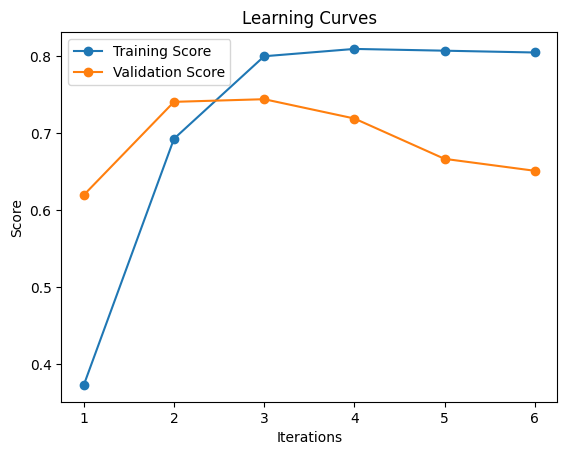

In [30]:
plot_learning_curves(train_results, val_results)

### A quick look at the regression coefficients in this tuned model

In [31]:
gene_data = pd.read_csv('../data/raw/gene_expression_matrix_2016-03-03/rows-genes.csv')
gene_list = np.array(ml_df.set_index('rnaseq_profile_id').columns[:-1])

log_reg_coefs = best_model.coef_.tolist()[0]

gene_ids_ranking = (
pd.DataFrame.from_dict({k:v for k,v in zip(gene_list, log_reg_coefs)}, orient = 'index', columns= ['coef'])
.rename_axis('gene_id')
.reset_index()
.sort_values(by='coef', ascending= False)
)
gene_ids_ranking = gene_ids_ranking.merge(gene_data, on='gene_id')
gene_ids_ranking

,gene_id,coef,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499336992,0.364975,12,5426,POLE,"polymerase (DNA directed), epsilon, catalytic ..."
1,499315843,0.214251,4,285489,DOK7,docking protein 7
2,499343767,0.204959,16,101927793,LOC101927793,uncharacterized LOC101927793
3,499317231,0.203092,4,4085,MAD2L1,MAD2 mitotic arrest deficient-like 1 (yeast)
4,499348546,0.146097,19,23152,CIC,capicua transcriptional repressor
5,499334626,0.144698,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
6,499350441,0.143437,20,140876,FAM65C,"family with sequence similarity 65, member C"
7,499329195,0.104142,9,85301,COL27A1,"collagen, type XXVII, alpha 1"
8,499323096,0.104034,7,79778,MICALL2,MICAL-like 2
9,499323166,0.086232,7,84629,TNRC18,trinucleotide repeat containing 18


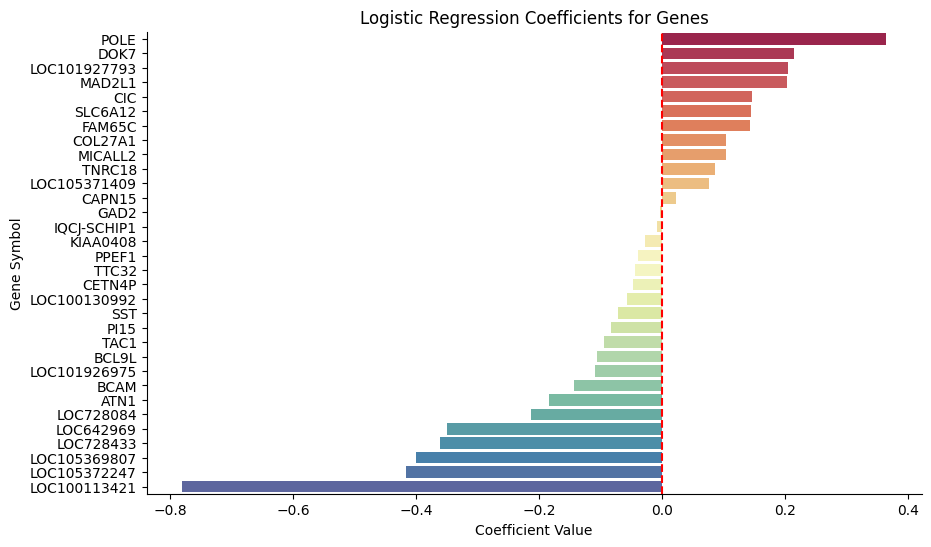

In [32]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='coef', y='gene_symbol', data=gene_ids_ranking, palette='Spectral')
plt.title('Logistic Regression Coefficients for Genes')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(0,color="red",linestyle="--")
plt.show()

In [33]:
# Define models to test
models = [
    best_model,
]

# List of model_names for output
model_names = [
    "Logistic Regression",
]
train_models(models, model_names, X_train, y_train, X_test, y_test)

,accuracy,precision,recall,f1
Logistic Regression,0.654206,0.657895,0.510204,0.574713


The tuned logistic regression model also performs poorly, but better than the gradient boosted model.

### Ensemble Model woth Voting Classifier

Becasue the base SVM and Guassian Classifier perform the best on this data, we create an ensemble model to balance the tradeoffs of each model, and evaluate its performance on all of the data sets.

In [34]:
# VotingClassifier (ensemble)

clf1 = GaussianNB()
clf2 = SVC(kernel="rbf", random_state=42)
# Evaluate the models ensemble with different weight given to each model
weights = [[1, 1], [2, 1], [1, 2]]
for w in weights:
    print(f'for weights; {w}')
    # Ensemble model
    eclf = VotingClassifier(estimators=[("NB", clf1), ("SVC", clf2)], weights= w).fit(X_train, y_train)
    train_preds = eclf.predict(X_train)
    val_preds = eclf.predict(X_val)
    test_preds = eclf.predict(X_test)

    train_score = np.round(f1_score(y_train, train_preds),3)
    val_score = np.round(f1_score(y_val, val_preds),3)
    test_score = np.round(f1_score(y_test, test_preds),3)

    average = np.mean((train_score, val_score, test_score))

    print(f'train score: {train_score} | val score: {val_score} | test score: {test_score} | average: {average}')

for weights; [1, 1]
train score: 0.769 | val score: 0.759 | test score: 0.588 | average: 0.7053333333333334
for weights; [2, 1]
train score: 0.751 | val score: 0.839 | test score: 0.74 | average: 0.7766666666666667
for weights; [1, 2]
train score: 0.824 | val score: 0.75 | test score: 0.615 | average: 0.7296666666666667


The ensemble model performs better overall when weighted towards the NB classifier.

### Metrics and scoring

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, class_likelihood_ratios

In [50]:
# clf1 = GaussianNB()
# clf2 = SVC(kernel="rbf", random_state=42, probability= True)
# clf3 = LogisticRegression(C=0.1, random_state=42)

# w = [2,1,1]
# eclf = VotingClassifier(estimators=[("NB", clf1), ("SVC", clf2), ('LR', clf3)], weights= w, voting='soft')
# models = [clf1, clf2, clf3, eclf]

# for model in models:
#     model.fit(X_train, y_train)
#     ax = plt.gca()
#     disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax = ax, alpha = 0.8)

# plt.title('Precision-Recall Curve Comparison')
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# plt.show()

In [51]:
# Weights
w = [2,1]


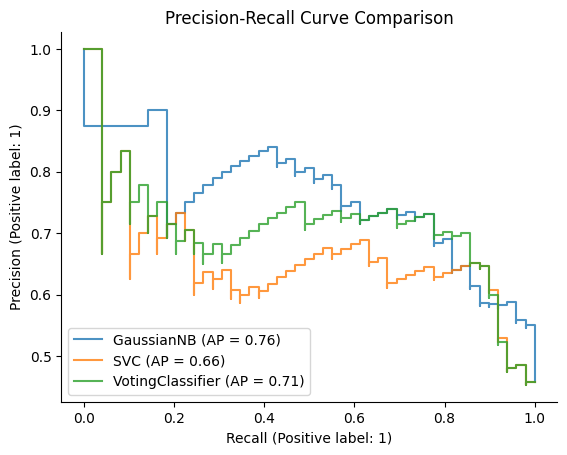

In [52]:
clf1 = GaussianNB()
clf2 = SVC(kernel="rbf", random_state=42, probability= True)
eclf = VotingClassifier(estimators=[("NB", clf1), ("SVC", clf2)], weights= w, voting='soft')
models = [clf1, clf2, eclf]

for model in models:
    model.fit(X_train, y_train)
    ax = plt.gca()
    disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax = ax, alpha = 0.8)

plt.title('Precision-Recall Curve Comparison')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

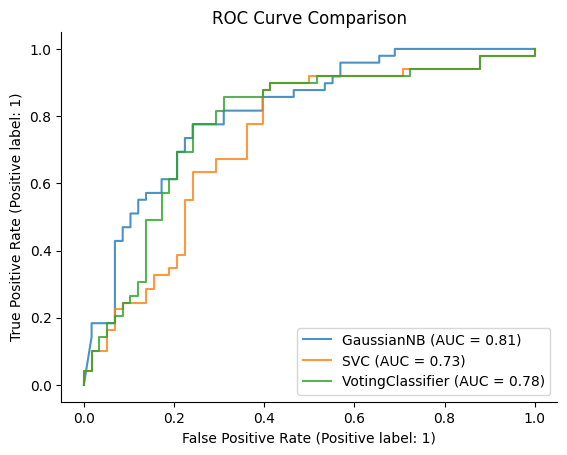

In [53]:
for model in models:
    model.fit(X_train, y_train)
    ax = plt.gca()
    disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax = ax, alpha = 0.8)

plt.title('ROC Curve Comparison')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

The Guassian Classifier is still the best performer.

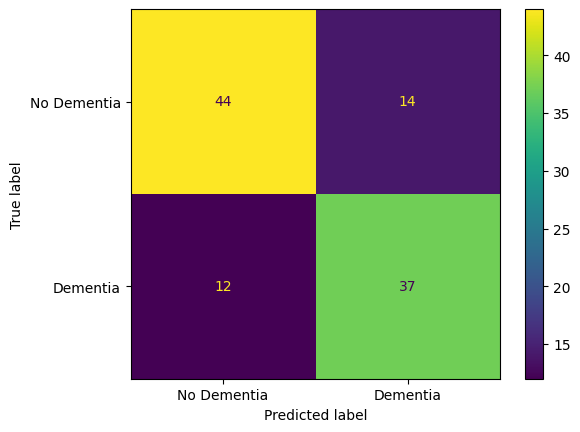

In [57]:
clf1 = GaussianNB()
clf1.fit(X_train, y_train)
preds = clf1.predict(X_test)
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Dementia', 'Dementia'])
disp.plot()
plt.show()

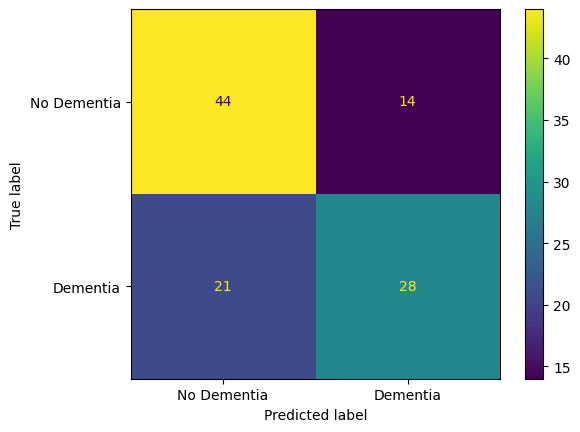

In [58]:
clf2 = SVC(kernel="rbf", random_state=42)
clf2.fit(X_train, y_train)
preds = clf2.predict(X_test)
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Dementia', 'Dementia'])
disp.plot()
plt.show()

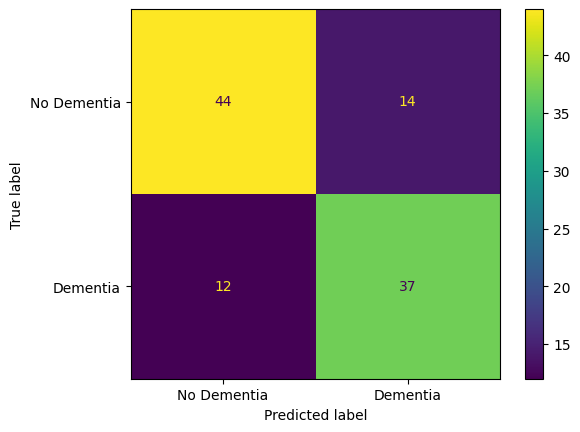

In [59]:
clf1 = GaussianNB()
clf2 = SVC(kernel="rbf", random_state=42)
eclf = VotingClassifier(estimators=[("NB", clf1), ("SVC", clf2)], weights= w)

eclf.fit(X_train, y_train)
preds = eclf.predict(X_test)
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Dementia', 'Dementia'])
disp.plot()
plt.show()

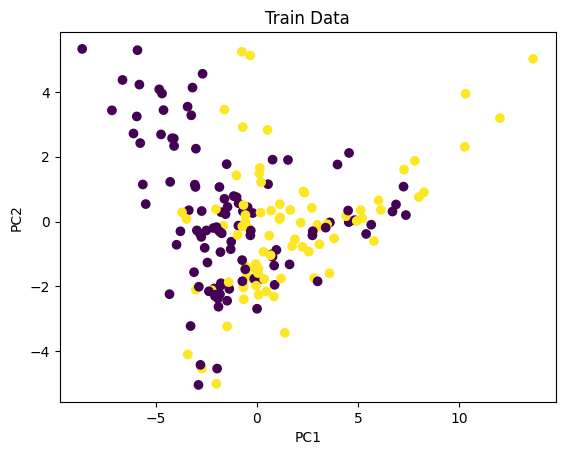

In [115]:
### Decision Boundary Testing
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state = 42)
X_ = pca.fit_transform(X_train)

plt.scatter(X_[:,0], X_[:,1], c = y_train, label = y_train)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Train Data')
plt.show()

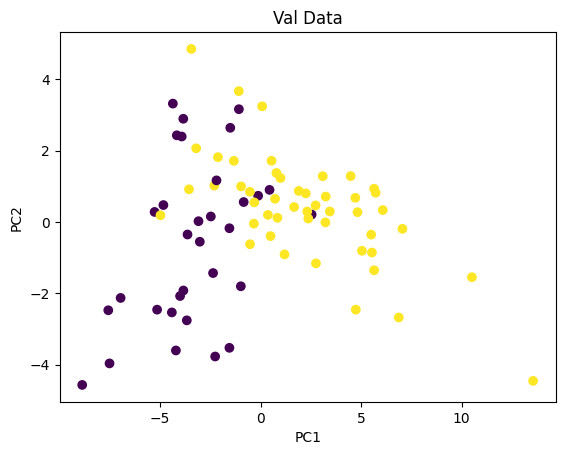

In [116]:
X_ = pca.fit_transform(X_val)

plt.scatter(X_[:,0], X_[:,1], c = y_val, label = y_val)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Val Data')
plt.show()

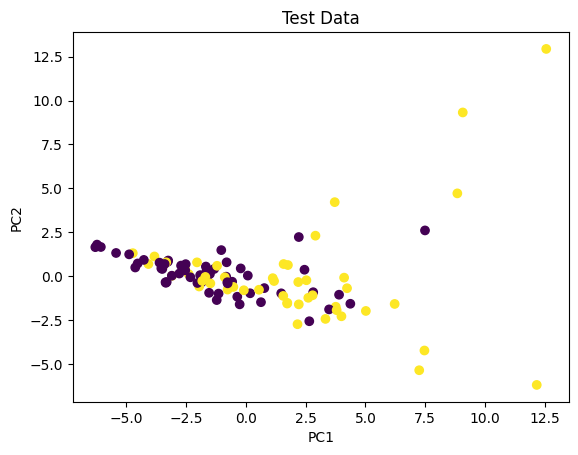

In [111]:
X_ = pca.fit_transform(X_test)
plt.scatter(X_[:,0], X_[:,1], c = y_test, label = y_test)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Test Data')
plt.show()

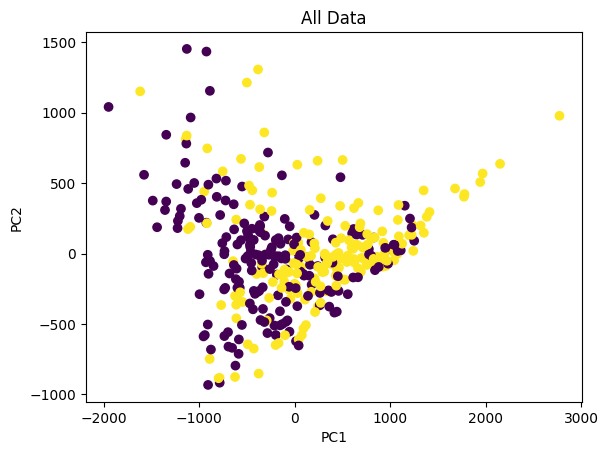

In [110]:
pca = PCA(n_components=2, random_state = 42)
X_ = pca.fit_transform(ml_df.iloc[:,1:-1].values)

labels = ml_df.iloc[:, -1].apply(lambda x: 0 if x == 'control' else 1)

plt.scatter(X_[:,0], X_[:,1], c = labels, label = labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('All Data')
plt.show()


### Permutation Importance

The permutation feature importance is a method used to assess the impact of individual features on a model's performance. It quantifies the decrease in the model's score when the values of a specific feature are randomly shuffled. By doing this, the procedure disrupts the relationship between the feature and the target variable, and the resulting drop in the model score indicates the extent to which the model relies on that particular feature.

This analysis helps identify the relative importance of different features in influencing the model's predictions. We will use this to interpret the feature importance of both the GaussianNB and Voting Classifier Model


In [60]:
clf1 = GaussianNB()
clf1.fit(X_train, y_train)
imps = permutation_importance(clf1, X_test, y_test, random_state= 42, n_repeats=100, scoring='roc_auc')
means = imps.importances_mean
deviations = imps.importances_std

NB_feature_importance_df = pd.DataFrame(zip(gene_list, means, deviations), columns= ['gene_id', 'importance', 'std']).merge(gene_data, on='gene_id').sort_values(by='importance', ascending= False)
NB_feature_importance_df.head(10)

,gene_id,importance,std,chromosome,gene_entrez_id,gene_symbol,gene_name
22,499336276,0.046867,0.017900,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene
12,499328351,0.034136,0.016728,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
26,499343769,0.015579,0.017666,16,105371409,LOC105371409,uncharacterized LOC105371409
20,499335939,0.010199,0.004957,12,105369807,LOC105369807,uncharacterized LOC105369807
6,499319747,0.009931,0.007726,5,101926975,LOC101926975,uncharacterized LOC101926975
5,499317260,0.006527,0.003454,4,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
18,499334626,0.006140,0.007511,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
27,499347240,0.005146,0.009169,19,105372247,LOC105372247,uncharacterized LOC105372247
29,499348654,0.003823,0.006991,19,4059,BCAM,basal cell adhesion molecule (Lutheran blood g...
25,499343767,0.003661,0.007868,16,101927793,LOC101927793,uncharacterized LOC101927793


In [61]:
NB_feature_importance_df['chromosome'].value_counts()

chromosome
12    6
9     3
16    3
4     3
19    3
7     3
3     2
10    2
5     1
2     1
11    1
20    1
X     1
8     1
6     1
Name: count, dtype: int64

Most of these genes are on chromosome 12

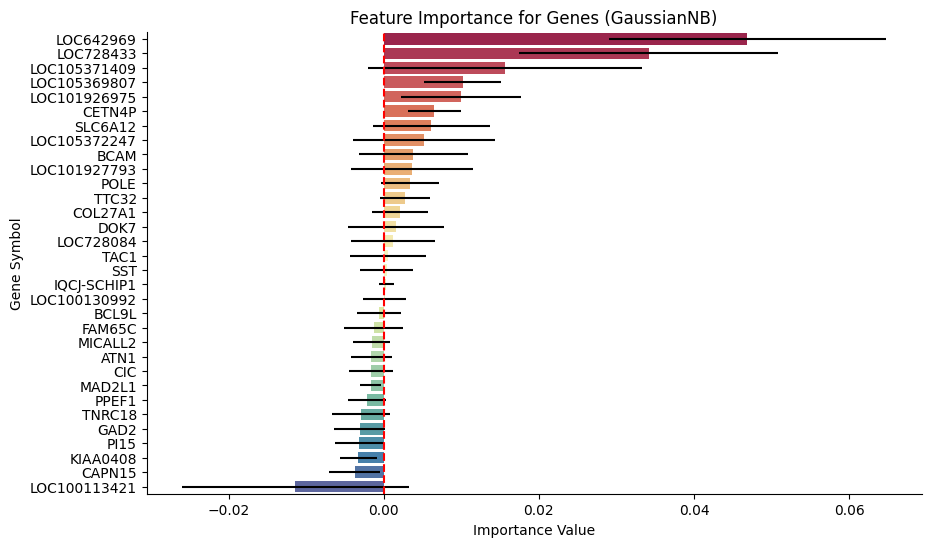

In [62]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='gene_symbol', data=NB_feature_importance_df, xerr=NB_feature_importance_df['std'],palette='Spectral')
plt.title('Feature Importance for Genes (GaussianNB)')
plt.xlabel('Importance Value')
plt.ylabel('Gene Symbol')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(0,color="red",linestyle="--")
plt.show()

In [63]:
thresh = NB_feature_importance_df['importance'].abs()-NB_feature_importance_df['std'] > 0
NB_sigs = NB_feature_importance_df[thresh]
NB_sigs


,gene_id,importance,std,chromosome,gene_entrez_id,gene_symbol,gene_name
22,499336276,0.046867,0.017900,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene
12,499328351,0.034136,0.016728,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
20,499335939,0.010199,0.004957,12,105369807,LOC105369807,uncharacterized LOC105369807
6,499319747,0.009931,0.007726,5,101926975,LOC101926975,uncharacterized LOC101926975
5,499317260,0.006527,0.003454,4,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
4,499317231,-0.001703,0.001296,4,4085,MAD2L1,MAD2 mitotic arrest deficient-like 1 (yeast)
11,499326780,-0.003130,0.003127,8,51050,PI15,peptidase inhibitor 15
7,499322427,-0.003265,0.002371,6,9729,KIAA0408,KIAA0408
24,499342049,-0.003719,0.003301,16,6650,CAPN15,calpain 15


In [64]:
NB_sigs['chromosome'].value_counts()

chromosome
12    2
4     2
9     1
5     1
8     1
6     1
16    1
Name: count, dtype: int64

In [65]:
clf1 = GaussianNB()
clf2 = SVC(kernel="rbf", random_state=42, probability= True)
eclf = VotingClassifier(estimators=[("NB", clf1), ("SVC", clf2)], weights= w, voting='soft')
models = [clf1, clf2, eclf]
eclf.fit(X_train, y_train)
imps = permutation_importance(eclf, X_test, y_test, random_state= 42, n_repeats=100, scoring='roc_auc')
means = imps.importances_mean
deviations = imps.importances_std

Vote_feature_importance_df = pd.DataFrame(zip(gene_list, means, deviations), columns= ['gene_id', 'importance', 'std']).merge(gene_data, on='gene_id').sort_values(by='importance', ascending= False)
Vote_feature_importance_df.head(10)

,gene_id,importance,std,chromosome,gene_entrez_id,gene_symbol,gene_name
12,499328351,0.028540,0.014145,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
20,499335939,0.027044,0.008844,12,105369807,LOC105369807,uncharacterized LOC105369807
22,499336276,0.026168,0.014621,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene
5,499317260,0.010799,0.004704,4,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
6,499319747,0.010345,0.006679,5,101926975,LOC101926975,uncharacterized LOC101926975
7,499322427,0.009212,0.004009,6,9729,KIAA0408,KIAA0408
18,499334626,0.007421,0.009243,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
21,499336206,0.005725,0.007309,12,728084,LOC728084,uncharacterized LOC728084
26,499343769,0.005002,0.012544,16,105371409,LOC105371409,uncharacterized LOC105371409
3,499315843,0.003881,0.007568,4,285489,DOK7,docking protein 7


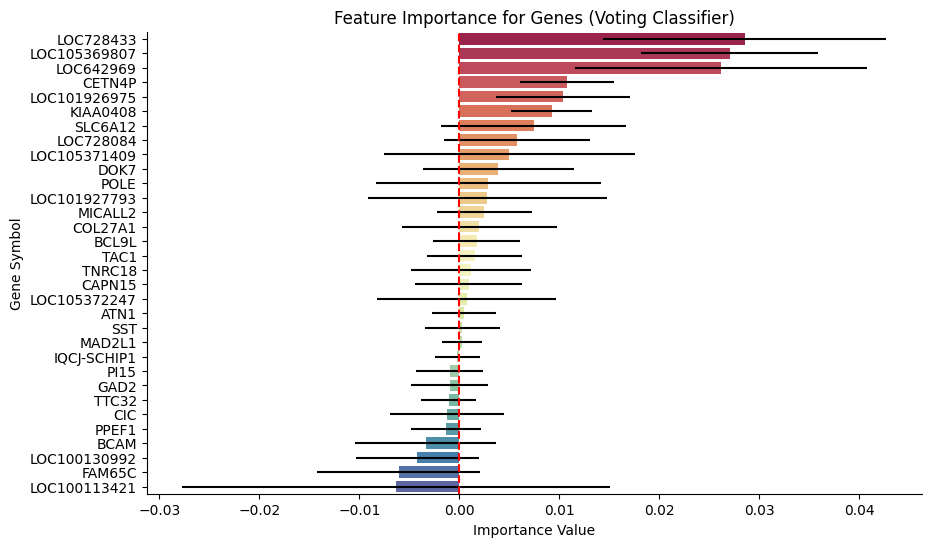

In [66]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='gene_symbol', data=Vote_feature_importance_df, xerr=Vote_feature_importance_df['std'], palette='Spectral')
plt.title('Feature Importance for Genes (Voting Classifier)')
plt.xlabel('Importance Value')
plt.ylabel('Gene Symbol')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.axvline(0,color="red",linestyle="--")
plt.show()

In [67]:
thresh = Vote_feature_importance_df['importance'].abs()-Vote_feature_importance_df['std'] > 0
Vote_sigs = Vote_feature_importance_df[thresh]
Vote_sigs

,gene_id,importance,std,chromosome,gene_entrez_id,gene_symbol,gene_name
12,499328351,0.028540,0.014145,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
20,499335939,0.027044,0.008844,12,105369807,LOC105369807,uncharacterized LOC105369807
22,499336276,0.026168,0.014621,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene
5,499317260,0.010799,0.004704,4,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
6,499319747,0.010345,0.006679,5,101926975,LOC101926975,uncharacterized LOC101926975
7,499322427,0.009212,0.004009,6,9729,KIAA0408,KIAA0408


In [68]:
Vote_sigs['chromosome'].value_counts()

chromosome
12    2
9     1
4     1
5     1
6     1
Name: count, dtype: int64

The is a large deviation in importance ranking, but the standard devations for the top rakings with the voting classifier appear to be noteably smaller.

Common genes:

In [69]:
common_genes = np.intersect1d(NB_sigs['gene_symbol'], Vote_sigs['gene_symbol'])
gene_data[gene_data['gene_symbol'].isin(common_genes)]

,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
12578,499317260,4,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
15065,499319747,5,101926975,LOC101926975,uncharacterized LOC101926975
17744,499322427,6,9729,KIAA0408,KIAA0408
23636,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
31224,499335939,12,105369807,LOC105369807,uncharacterized LOC105369807
31561,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene


Below are reference links for the detailed info of these top genes:
- [LOC728433](https://www.ncbi.nlm.nih.gov/gene/?term=728433)
- [KIAA0408](https://www.ncbi.nlm.nih.gov/gene/?term=9729)
- [CETN4P](https://www.ncbi.nlm.nih.gov/gene/?term=729338)
- [LOC105369807](https://www.ncbi.nlm.nih.gov/gene/?term=105369807)
- [LOC642969](https://www.ncbi.nlm.nih.gov/gene/?term=642969)
